<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/4.%20Generative%20Adversarial%20Networks%20(GANs)/3.%20Cyclic%20GANs/Image-to-Image%20Translation%20via%20Cyclic%20GANs/Image_to_image_translation_via_Cyclic_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Vizualize Data

In [0]:
import os
os.chdir('./sample_data')
print(os.getcwd())

!wget -N https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip

In [3]:
from zipfile import ZipFile
import os
print(os.getcwd())
zf = ZipFile('summer2winter-yosemite.zip', 'r')
zf.extractall('./')
zf.close()

/content/sample_data


# Import Required Libraries

In [0]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline


# Define DataLoaders

In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', image_size=128, batch_size=16, num_workers=0):

  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
  image_path = './'+image_dir
  print(os.getcwd())
  train_path = os.path.join(image_path, image_type)
  test_path  = os.path.join(image_path, 'test_{}'.format(image_type))

  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
  test_loader  = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

  return train_loader, test_loader

In [6]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloder_Y = get_data_loader(image_type='winter')

/content/sample_data
/content/sample_data


# Vizualize Data

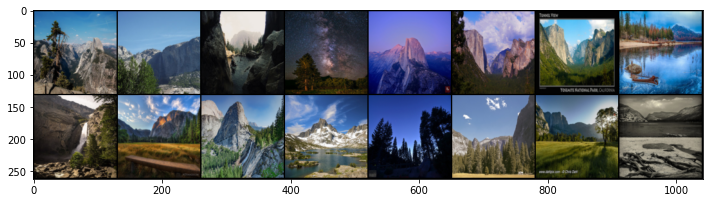

In [7]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

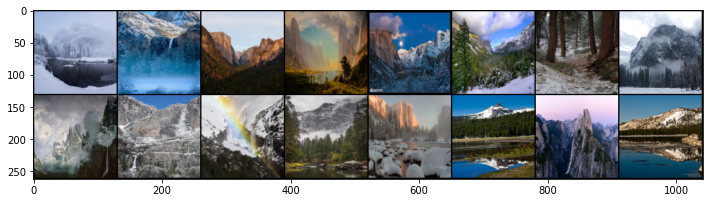

In [8]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

# Pre-processing: Scaling from -1 to 1

In [9]:
img = images[0]

print(img.min())
print(img.max())

tensor(0.0353)
tensor(0.9255)


In [0]:
def scale(x, feature_range=(-1, 1)):
  min, max = feature_range
  x = x*(max-min) + min
  return x

In [11]:
scaled_img = scale(images[9])

print('Scaled image : ', scaled_img.min())
print('Scaled image : ', scaled_img.max())

Scaled image :  tensor(-0.8745)
Scaled image :  tensor(0.9843)


# Convolutional Helper Function

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

# Discriminators

In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dim=64):
    super(Discriminator, self).__init__()

    self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
    self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4)
    
    self.conv5 = conv(conv_dim*8, 1, kernel_size=4, stride=1, batch_norm=False)
  
  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))

    out = self.conv5(out)
    return out

# Generators

G (x to y) and G(y to x)

Residual class - 

collection of 2 conv layers : 

Generates a new mapping : 

x -> F(x) + x 

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(conv_dim, conv_dim, kernel_size=3, stride=1)
    self.conv2 = conv(conv_dim, conv_dim, kernel_size=3, stride=1)
  
  def forward(self, x):
    out_1 = F.relu(self.conv1(x))
    out_2 = x + self.conv2(out_1)

    return out_2


# Generator - DeConv Helper Class

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(t_conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [0]:
class CycleGenerator(nn.Module):  
  def __init__(self, conv_dim=64, n_res_blocks=6):
    super(CycleGenerator, self).__init__()

    # 1. define the encoder part
    self.conv1 = conv(3, conv_dim, 4)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    res_layers = []
    for layer in range(n_res_blocks):
      res_layers.append(ResidualBlock(conv_dim*4))
    
    self.res_blocks = nn.Sequential(*res_layers)
    
    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
  
  def forward(self, x):

    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    out = self.res_blocks(out)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))

    out = F.tanh(self.deconv3(out))

    return out



# Create Models

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=4):
  G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
  G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)

  D_X = Discriminator(conv_dim=d_conv_dim)
  D_Y = Discriminator(conv_dim=d_conv_dim)

  if torch.cuda.is_available():
    G_XtoY.cuda()
    G_YtoX.cuda()

    D_X.cuda()
    D_Y.cuda()
  else:
    print('GPU not available')
  
  return G_XtoY, G_YtoX, D_X, D_Y


In [0]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

In [19]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

# Defining Loss and Optimizer for Cyclic GANs

In [0]:
def real_mse_loss(D_out):
  return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
  return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
  reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
  return lambda_weight * reconstr_loss


In [0]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimzier = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])